# Transfer Learning - Flowers

Este ejemplo fue extraido desde un sitio educacional de Google. Para ejecutar este ejemplo, se puede hacer con un backend GPU, pues no es un proceso muy demandante.

Este sitio que explica el ejemplo original ya no se encuentra disponible, para que se pueda usar, cambie cargas a manual, se debe instalar esto para pip: 


pip install tensorflow-datasets


o en el caso de usar coda: 

conda install -c conda-forge tensorflow-datasets

## Imports

In [48]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.16.2


In [50]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

## Configuración

In [ ]:
# Parámetros de los archivos TFRecord originales (no utilizados directamente en la versión local)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
SHARDS = 16
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']  # do not change, maps to the labels in the data (folder names)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of accelerators:  1
1e-05 5.9807360000000024e-05


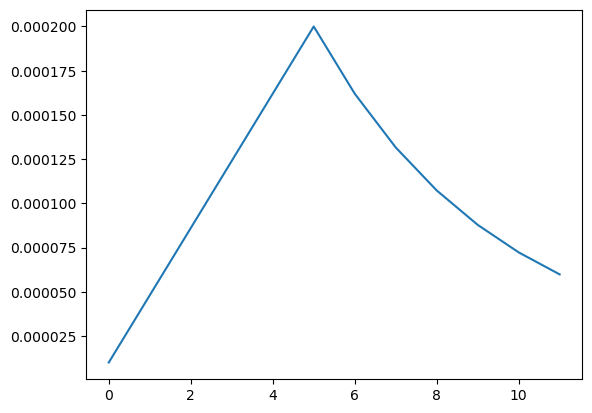

In [54]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

EPOCHS = 12
IMAGE_SIZE = [331, 331]

FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"


# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)
MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [56]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[labels[i]]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Lectura de imagenes y etiquetas desde TFRecords

In [58]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    }

    example = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
    class_label = example['class']
    
    return image, class_label


def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)

  return dataset
  

2025-12-30 17:31:42.091776: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


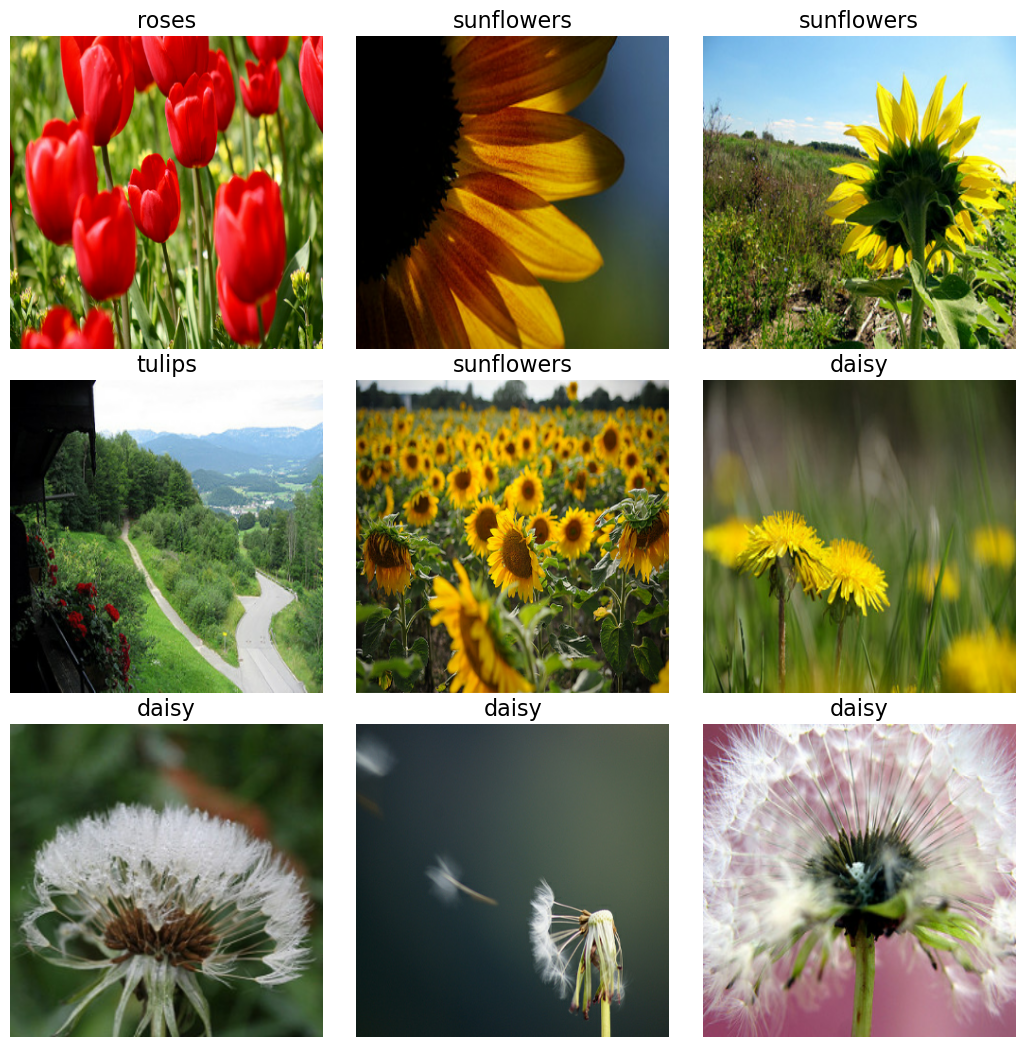

In [60]:
import tensorflow_datasets as tfds

# 1. Descargamos el dataset directamente a tu Mac/Colab
# Esto evitará cualquier error de "Permission Denied" de Google Cloud
dataset_name = "tf_flowers"
(ds_train), ds_info = tfds.load(
    dataset_name,
    split='train',
    with_info=True,
    as_supervised=True,  # Para que devuelva (imagen, etiqueta)
)

# 2. Re-adaptamos el dataset para que se parezca al original del curso
def preprocess_image(image, label):
    image = tf.image.resize(image, [331, 331])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

dataset = ds_train.map(preprocess_image)

# 3. Mostramos las imágenes usando tu función original
# Nota: display_9_images_from_dataset internamente llama a dataset_to_numpy_util
display_9_images_from_dataset(dataset)

## Training y Validation datasets

In [ ]:
# --- CONFIGURACIÓN DE RUTAS Y DATASETS ---

# 1. Definimos la ruta base de las flores (331x331)
gcs_path_base = "gs://flowers-public/tfrecords-jpeg-331x331/flowers"

# 2. Creamos la lista de archivos de ENTRENAMIENTO manualmente (del 00 al 15)
training_filenames = [f"{gcs_path_base}{i:02d}-16.tfrec" for i in range(16)]

# 3. Creamos la lista de archivos de VALIDACIÓN
#    (en este ejemplo usamos los mismos; podrías separarlos si tuvieras listas distintas)
validation_filenames = training_filenames

# 4. Definimos la función de procesamiento por lotes (Batching)
def get_batched_dataset(filenames, train: bool = False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache()  # Mantiene los datos en RAM para mayor velocidad

    if train:
        # Repetimos solo el dataset de entrenamiento
        dataset = dataset.repeat()
        # Aquí podrías agregar dataset.shuffle(2048) si fuera necesario

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)  # Prepara el siguiente lote mientras entrena

    return dataset

# 5. Instanciamos los datasets finales
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

# 6. Calculamos el número de pasos por época y validación
num_train = 0
for _image, _label in load_dataset(training_filenames):
    num_train += 1

num_valid = 0
for _image, _label in load_dataset(validation_filenames):
    num_valid += 1

steps_per_epoch = num_train // BATCH_SIZE
validation_steps = num_valid // VALIDATION_BATCH_SIZE

print(f"Imágenes de entrenamiento: {num_train}")
print(f"Imágenes de validación: {num_valid}")
print("Se usarán {} batches por epoch y {} batches para validación.".format(steps_per_epoch, validation_steps))

Éxito: Se han configurado 16 archivos para entrenamiento.
Batch size: 16
Datasets listos para el entrenamiento.


## Modelo Neuronal [IMPLEMENTAR]
1. Start with a dummy single-layer model using one dense layer:
 * Use  a [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) model. The constructor takes a list of layers.
 * First, [`Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the pixel values of the the input image to a 1D vector so that a dense layer can consume it:<br/>
 `tf.keras.layers.Flatten(input_shape=[*IMAGE_SIZE, 3])  # the first layer must also specify input shape`
 * Add a single [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers):<br/>
  `tf.keras.layers.Dense(5, activation='softmax')`
 * add the last bits and pieces with [model.compile()](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#compile). For a classifier, you need `'sparse_categorical_crossentropy'` loss, `'accuracy'` in metrics and you can use the `'adam'` optimizer.

 **==>Train this model: not very good... but all the plumbing is in place.**

1. Instead of trying to figure out a better architecture, we will adapt a pretrained model to our data. Please remove all your layers to restart from scratch.
 * Instantiate a pre-trained model from `tf.keras.applications.*`
 You do not need its final softmax layer (`include_top=False`) because you will be adding your own. This code is already written in the cell below.<br/>
 * Use `pretrained_model` as your first "layer" in your Sequential model.
 * Follow with  [`tf.keras.layers.Flatten()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) or [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) to turn the data from the pretrained model into a flat 1D vector.
 * Add your [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation and the correct number of units (hint: 5 classes of flowers).

 **==>Train the model: you should be able to reach above 75% accuracy by training for 10 epochs**

1. You can try adding a second dense layer. Use 'relu' activation on all dense layers but the last one which must be 'softmax'. An additional layer ads trainable weights. It is unlikely to do much good here though, because our dataset is too small.

This technique is called "transfer learning". The pretrained model has been trained on a different dataset but its layers have still learned to recognize bits and pieces of images that can be useful for flowers. You are retraining the last layer only, the pretrained weights are frozen. With far fewer weights to adjust, it works with less data.

In [73]:
# --- BLOQUE ÚNICO DE CARGA Y ENTRENAMIENTO (REEMPLAZA TU CELDA DE ERROR CON ESTO) ---

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# 1. CARGA LOCAL (Descarga directa, sin problemas de permisos de Google Cloud)
print("Descargando dataset de flores... (aprox. 200MB)")
dataset_name = "tf_flowers"
(ds_train, ds_valid), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'], # 80% entrenamiento, 20% validación
    with_info=True,
    as_supervised=True
)

# 2. PROCESAMIENTO
IMAGE_SIZE_LOCAL = [331, 331]
BATCH_SIZE_LOCAL = 16

def preprocess_local(image, label):
    image = tf.image.resize(image, IMAGE_SIZE_LOCAL)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Configuración del pipeline de datos
train_ds = ds_train.map(preprocess_local).cache().shuffle(1000).batch(BATCH_SIZE_LOCAL).repeat().prefetch(tf.data.AUTOTUNE)
valid_ds = ds_valid.map(preprocess_local).batch(BATCH_SIZE_LOCAL).cache().prefetch(tf.data.AUTOTUNE)

# 3. DEFINICIÓN DEL MODELO SIMPLE
print("Construyendo el modelo...")
simple_model = Sequential([
    Flatten(input_shape=(331, 331, 3)),
    Dense(5, activation='softmax')
])

simple_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. CÁLCULO DE PASOS
steps_per_epoch = (ds_info.splits['train'].num_examples * 0.8) // BATCH_SIZE_LOCAL
validation_steps = (ds_info.splits['train'].num_examples * 0.2) // BATCH_SIZE_LOCAL

# 5. ENTRENAMIENTO
print(f"Iniciando entrenamiento local (Epochs: 5)...")
history_simple = simple_model.fit(
    train_ds,
    validation_data=valid_ds,
    steps_per_epoch=int(steps_per_epoch),
    validation_steps=int(validation_steps),
    epochs=5
)

Descargando dataset de flores... (aprox. 200MB)
Construyendo el modelo...
Iniciando entrenamiento local (Epochs: 5)...
Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.2915 - loss: 47.3599 - val_accuracy: 0.3306 - val_loss: 31.6321
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.4003 - loss: 24.9346

2025-12-30 17:41:19.988569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.4003 - loss: 24.9361 - val_accuracy: 0.1429 - val_loss: 24.4887
Epoch 3/5
  4/183 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.3278 - loss: 20.7574

/Users/gio/Anaconda/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.4397 - loss: 22.9367 - val_accuracy: 0.3847 - val_loss: 29.8170
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.5006 - loss: 17.0723 - val_accuracy: 0.6429 - val_loss: 19.3325
Epoch 5/5
  1/183 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.3750 - loss: 29.2954

2025-12-30 17:41:46.938015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


183/183 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4856 - loss: 27.2825 - val_accuracy: 0.4042 - val_loss: 22.7203


In [75]:
# modelos pre-entrenados
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
#pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
#pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False


/var/folders/z7/s8_bm31j1vqbws7fljh6p4xw0000gn/T/ipykernel_16409/3644029015.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# implementar arquitectura
# [COMPLETADO]

with strategy.scope():
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])

In [ ]:
# compilacion del modelo
# [COMPLETADO]

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# sumario del modelo
# [COMPLETADO]

model.summary()

## Training

In [ ]:
# Entrenamiento
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

In [ ]:
# Evaluacion del modelo
print(model.evaluate(validation_dataset))

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predicciones

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
